# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24, RF = 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1, RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        # x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             720
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zero_vector)

    factor = 0.0005
    loss += factor * reg_loss


    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3873599171638489 Batch_id=468 Accuracy=86.40: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0962, Accuracy: 9738/10000 (97.38%)

EPOCH: 1


Loss=0.2655600607395172 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9840/10000 (98.40%)

EPOCH: 2


Loss=0.2060588002204895 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9819/10000 (98.19%)

EPOCH: 3


Loss=0.2258167564868927 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9825/10000 (98.25%)

EPOCH: 4


Loss=0.26652276515960693 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9830/10000 (98.30%)

EPOCH: 5


Loss=0.24812954664230347 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.201963871717453 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


Loss=0.2156810760498047 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.25157564878463745 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9898/10000 (98.98%)

EPOCH: 9


Loss=0.1697833240032196 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9877/10000 (98.77%)

EPOCH: 10


Loss=0.22130528092384338 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9862/10000 (98.62%)

EPOCH: 11


Loss=0.1783665120601654 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9879/10000 (98.79%)

EPOCH: 12


Loss=0.2569050192832947 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9869/10000 (98.69%)

EPOCH: 13


Loss=0.23611432313919067 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9843/10000 (98.43%)

EPOCH: 14


Loss=0.2610863745212555 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9838/10000 (98.38%)

EPOCH: 15


Loss=0.2309388518333435 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9850/10000 (98.50%)

EPOCH: 16


Loss=0.18128924071788788 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9854/10000 (98.54%)

EPOCH: 17


Loss=0.21658645570278168 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 44.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9846/10000 (98.46%)

EPOCH: 18


Loss=0.17957375943660736 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9882/10000 (98.82%)

EPOCH: 19


Loss=0.18949158489704132 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:13<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9881/10000 (98.81%)

EPOCH: 20


Loss=0.16788186132907867 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:12<00:00, 36.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9838/10000 (98.38%)

EPOCH: 21


Loss=0.14824478328227997 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9872/10000 (98.72%)

EPOCH: 22


Loss=0.2172093689441681 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9878/10000 (98.78%)

EPOCH: 23


Loss=0.1725843995809555 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9876/10000 (98.76%)

EPOCH: 24


Loss=0.20226120948791504 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 42.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9846/10000 (98.46%)

EPOCH: 25


Loss=0.2564467489719391 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9906/10000 (99.06%)

EPOCH: 26


Loss=0.17797508835792542 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9905/10000 (99.05%)

EPOCH: 27


Loss=0.16691192984580994 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9896/10000 (98.96%)

EPOCH: 28


Loss=0.1773829162120819 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9845/10000 (98.45%)

EPOCH: 29


Loss=0.14289866387844086 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9901/10000 (99.01%)

EPOCH: 30


Loss=0.25633805990219116 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9881/10000 (98.81%)

EPOCH: 31


Loss=0.18679548799991608 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9853/10000 (98.53%)

EPOCH: 32


Loss=0.17601078748703003 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9826/10000 (98.26%)

EPOCH: 33


Loss=0.19137048721313477 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9901/10000 (99.01%)

EPOCH: 34


Loss=0.1686604917049408 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9865/10000 (98.65%)

EPOCH: 35


Loss=0.20070794224739075 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9865/10000 (98.65%)

EPOCH: 36


Loss=0.14435385167598724 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9879/10000 (98.79%)

EPOCH: 37


Loss=0.24258029460906982 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9875/10000 (98.75%)

EPOCH: 38


Loss=0.21737690269947052 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9864/10000 (98.64%)

EPOCH: 39


Loss=0.1772049218416214 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]



Test set: Average loss: 0.0534, Accuracy: 9830/10000 (98.30%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Loss with L1')

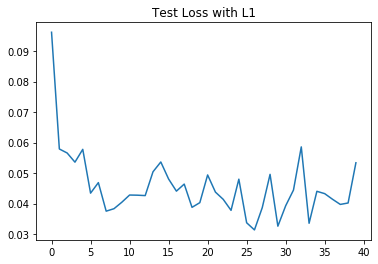

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(test_losses)
plt.title("Test Loss with L1")

Text(0.5, 1.0, 'Test Accuracy with L1')

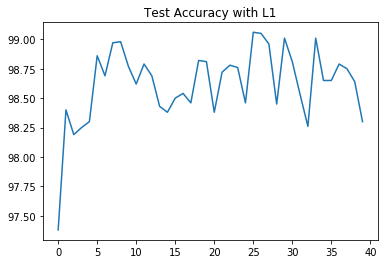

In [24]:
plt.plot(test_acc)
plt.title("Test Accuracy with L1")

Text(0.5, 1.0, 'Test Accuracy with L1')

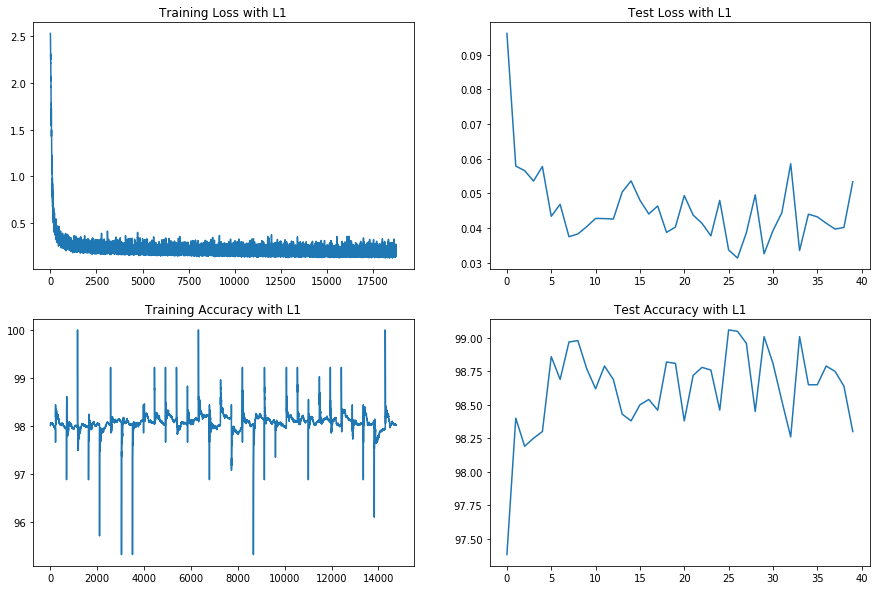

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss with L1")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy with L1")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss with L1")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy with L1")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


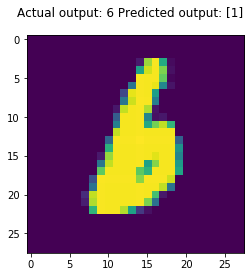

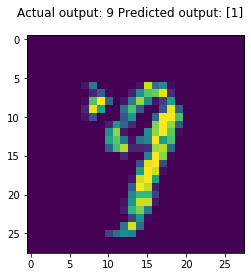

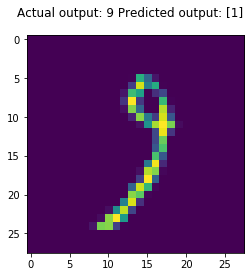

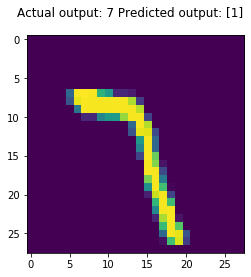

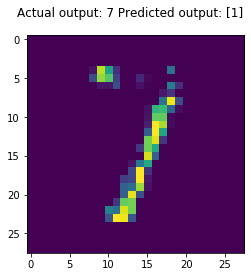

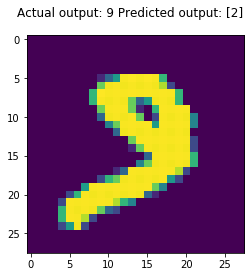

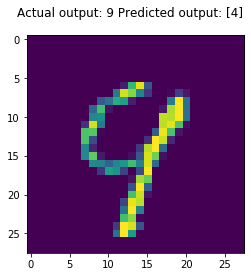

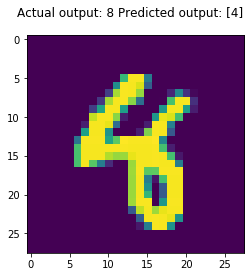

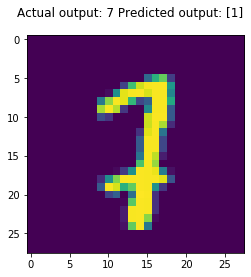

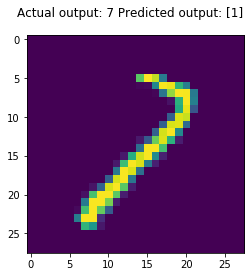

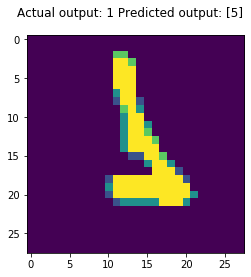

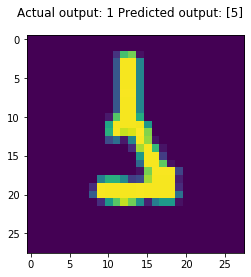

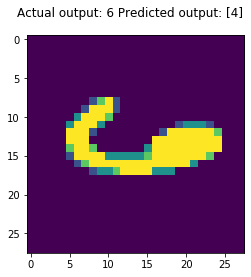

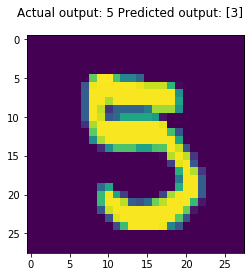

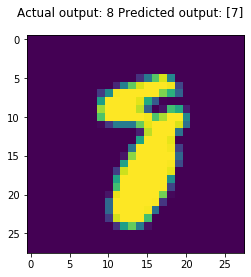

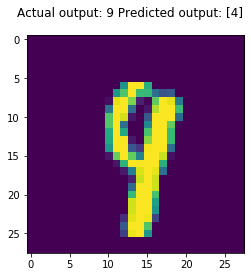

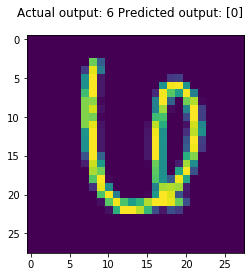

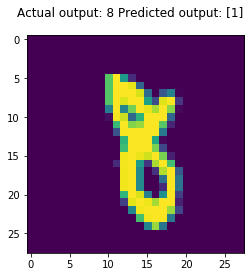

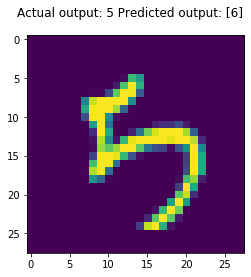

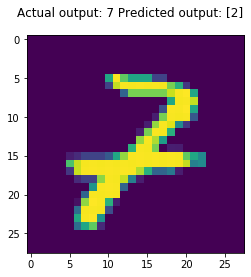

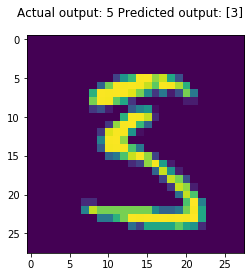

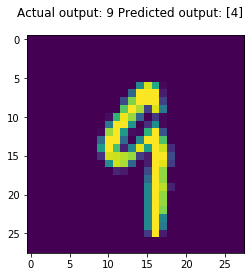

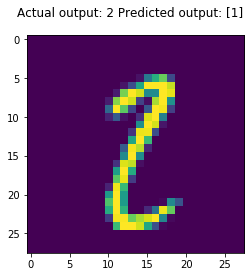

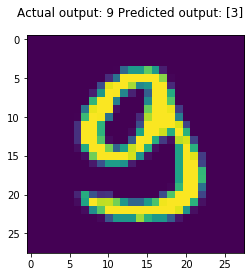

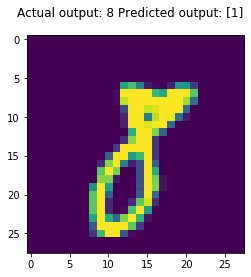

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig(str(count)+".jpg")
                files.download(str(count)+".jpg")
                count = count+1